## Problem Description and Data

The goal of this project is to build a Convolutional Neural Network that would classify metastatic cancer in small image patches. The dataset used is provided by Kaggle: Histopathologic Cancer Detection: <https://www.kaggle.com/c/histopathologic-cancer-detection/data>

The data downloaded here is split into train and test sets, and it is the test set that will determine the final Kaggle score. The dataset consists of 96 by 96 pixel images with 3 color channels for a total of 27,648 total inputs per image. However, only the center 32 by 32 pixel patch of each image actually determines the classification (according to Kaggle). Each image comes in a .tif format and is named {id}.tif. For the training set, a csv is also provided where the images id is recorded as either 1 (positive for metastatic cancer) or 0 (negative for metastatic cancer). 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Set this before importing TensorFlow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import seaborn as sns
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


In [ ]:
# Test GPU Working Correctly
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("TensorFlow is using the GPU.")
else:
    print("TensorFlow is using the CPU.")

TensorFlow is using the GPU.


Below is an example of one of these image files. This particular image is negative for metastatic cancer.

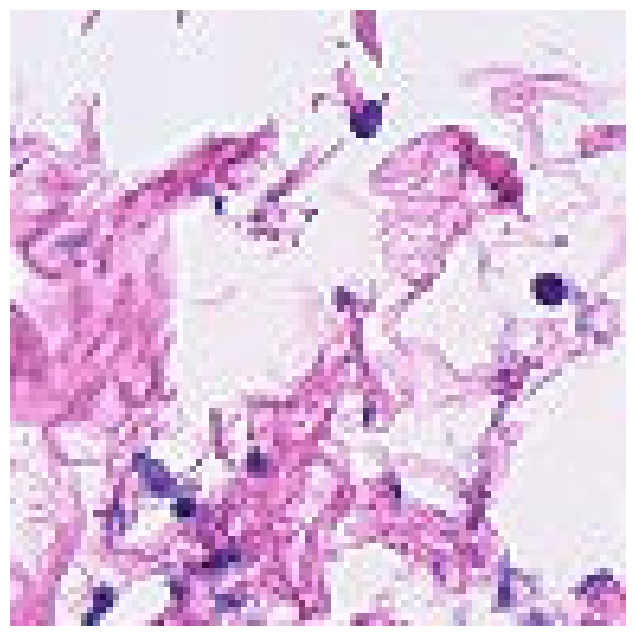

In [3]:
image = Image.open('./data/train/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif')
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

## EDA 

### Initial Conseriderations: Dataset Preview, Missing Data, Dataset Skew

#### 1. Dataset Preview
Previewing the dataset is a key first step to understand its structure and quality. We'll examine a few samples with both positive and negative labels to:
- Validate label accuracy.
- Observe data characteristics like patterns or anomalies.

This helps ensure the dataset is ready for analysis and modeling.

In [4]:
#Load training dataset labels:
data_labels = pd.read_csv('./data/train_labels.csv')
data_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


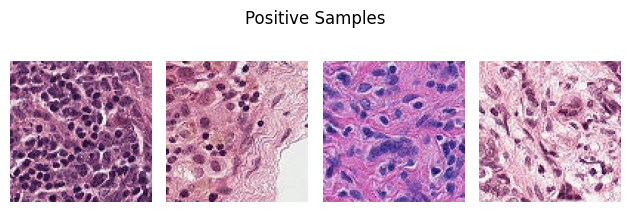

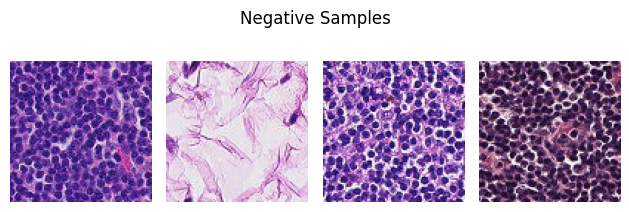

In [5]:
# Printing off some samples of both positive and negative cases
num_samples = 4

positive_samples = data_labels.loc[data_labels['label'] == 1].sample(num_samples)
negative_samples = data_labels.loc[data_labels['label'] == 0].sample(num_samples)

fig, axes = plt.subplots(1, num_samples)
for idx, a in enumerate(axes):
    image = Image.open('./data/train/' + positive_samples.iloc[idx]['id'] + '.tif')
    a.imshow(image)
    a.axis('off')
fig.suptitle("Positive Samples", y=.72)
plt.tight_layout()

fig, axes = plt.subplots(1, num_samples)
for idx, a in enumerate(axes):
    image = Image.open('./data/train/' + negative_samples.iloc[idx]['id'] + '.tif')
    a.imshow(image)
    a.axis('off')
fig.suptitle("Negative Samples", y=.72)
plt.tight_layout()



To my untrained eye, I am unable to spot what exactly would classify these sets of images one way or the other, so I'll continue with the analysis further.

#### 2. Missing Data
A quick check is necessary to ensure data completeness. We'll verify that:
- All images in the dataset have associated labels in the CSV file.
- The CSV file does not contain entries without corresponding images.

This step is crucial to avoid issues during training and analysis due to missing or mismatched data.

In [6]:
# Missing Data Check

# First to see if there are any non-labeled ids:
print("Check to see if data labels have any missing data\n", data_labels.isna().sum())
# No missing labels at least in the csv

# Check to see if all labels in the csv have a matching .tif
# Extract all expected file paths from the labels DataFrame
label_ids = data_labels['id'].tolist()
missing_files = []
# Check for each label if the corresponding .tif file exists
for label_id in label_ids:
    image_path = os.path.join('./data/train', f"{label_id}.tif")
    if not os.path.exists(image_path):
        missing_files.append(label_id)

print('Number of missing tif files:', len(missing_files))

Check to see if data labels have any missing data
 id       0
label    0
dtype: int64
Number of missing tif files: 0


No missing data is present, so I'm free to move towards the next consideration.

#### 3. Dataset Skew

Class imbalance in the training dataset, where one class significantly outnumbers the other, can impact model performance. I'll analyze the distribution of positive and negative cases to assess any skew. If necessary, techniques like resampling, weighting, or synthetic data generation may be applied to address the imbalance and improve model performance.



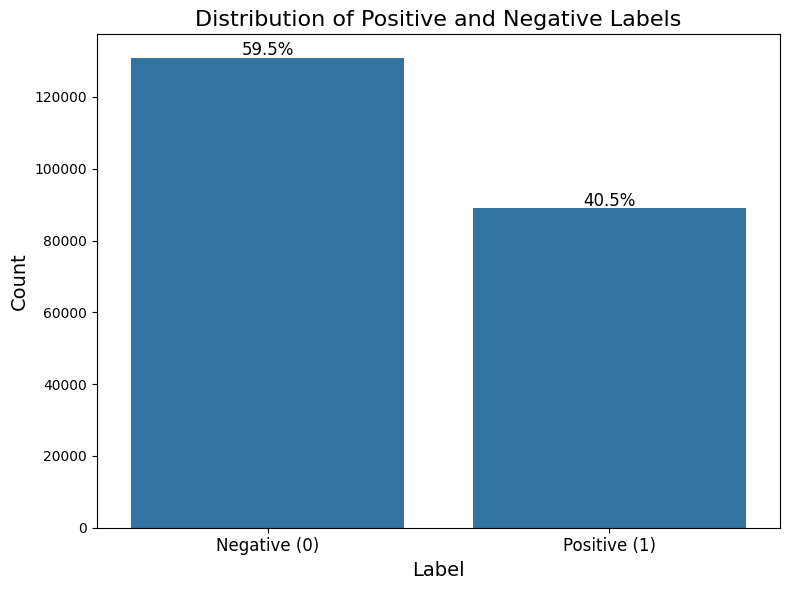

In [7]:
# Extract label counts and percentages
label_counts = data_labels['label'].value_counts()
total_samples = len(data_labels)
percentages = (label_counts / total_samples) * 100


plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)

# Annotate percentages on the bars
for i, (count, percentage) in enumerate(zip(label_counts.values, percentages)):
    plt.text(i, count*1.005, f"{percentage:.1f}%", ha='center', fontsize=12)

plt.title("Distribution of Positive and Negative Labels", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["Negative (0)", "Positive (1)"], fontsize=12)
plt.tight_layout()

plt.show()


This distribution is fairly well balanced, so I will not apply any techniques for skew.

## Description of Model

The data appears to be of good quality, with no missing labels and minimal dataset skew. So I will procede with choosing a model architecture:

**Model Architecture**:
- Repeating block: `(CNN → CNN → MaxPool) * n`, where `n = 3` initially (this will be adjustable as the model is refined).
- A dense classifier section.

### Initial CNN Design:
- **CNN Layers**: 
  - First layer: 32 filters
  - Second layer: 16 filters
  - Third layer: 8 filters
- Early CNN layers will focus on capturing basic features, while later layers will combine these into more complex patterns to enhance classification performance.

### Classifier Section:
- Two dense layers:
  - 128 nodes
  - 64 nodes
- Final output layer with 1 node for binary classification.

### Activation Functions:
- All hidden layers: ReLU activation
- Output layer: Sigmoid activation for binary classification.

I will compare this initial basic model to:
1. A deeper model (`n = 4`) to assess the impact of additional layers.
2. A wider model with a higher initial filter count to explore the benefits of increased feature extraction capacity.

These basic models will serve as the foundation for further refinement and experimentation.





In [8]:
basic_model = tf.keras.Sequential([
    tf.keras.Input(shape=(96, 96, 3)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')


])
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.92,
    staircase=True)

basic_model.summary()
basic_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 16)        4624      
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 16)       0         
 2D)                                                    

#### Creating the Dataset

Before training the model, I need to create a TensorFlow dataset to act as the data pipeline for feeding data into the model. The original dataset will be split into:
- **Training Set**: 80% of the data, used for model training via backpropagation through each epoch.
- **Validation Set**: 20% of the data, used to calculate accuracy and loss at the end of each epoch for model evaluation.

The validation set will remain consistent across the three basic models, ensuring that their performance (in terms of loss and accuracy) is directly comparable. 

### Training Process:
- Each model will be trained for **10 epochs** initially.
- The best-performing model will be selected based on validation accuracy and loss for further training.
- This winning model will then be used to generate predictions on the test dataset as our initial guess.

In [9]:
# Split into train and validation
train_df, validation_df = train_test_split(data_labels, test_size=0.2, random_state=42)


# Dataset Maker
# Path to the folder containing the .tif images
image_folder = "./data/train/"

# Function to load image
def load_image(image_id):
    image_path = os.path.join(image_folder, f"{image_id}.tif")
    image = Image.open(image_path)
    return tf.convert_to_tensor(image, dtype=tf.float32) / 255.0 

# Function to process an ID and label
def process_row(row):
    image = load_image(row['id'])
    label = tf.convert_to_tensor(int(row['label']), dtype=tf.int32)
    return image, label

    # Create a list of tuples (id, label) from the dataframe
train_data = list(zip(train_df['id'], train_df['label']))
validation_data = list(zip(validation_df['id'], validation_df['label']))

# Create a TensorFlow Dataset
def train_generator():
    for id_, label in train_data:
        yield load_image(id_), tf.convert_to_tensor(int(label), dtype=tf.int32)

def validation_df():
    for id_, label in validation_data:
        yield load_image(id_), tf.convert_to_tensor(int(label), dtype=tf.int32)

# Create the tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    validation_df,
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)


BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Inital Basic Model Training

In [10]:

basic_hist = basic_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)


Epoch 1/10
2751/2751 [==============================] - 260s 93ms/step - loss: 0.4573 - accuracy: 0.7842 - val_loss: 0.4150 - val_accuracy: 0.8151
Epoch 2/10
2751/2751 [==============================] - 259s 94ms/step - loss: 0.3949 - accuracy: 0.8268 - val_loss: 0.3662 - val_accuracy: 0.8419
Epoch 3/10
2751/2751 [==============================] - 249s 90ms/step - loss: 0.3646 - accuracy: 0.8423 - val_loss: 0.3463 - val_accuracy: 0.8522
Epoch 4/10
2751/2751 [==============================] - 249s 90ms/step - loss: 0.3434 - accuracy: 0.8528 - val_loss: 0.3267 - val_accuracy: 0.8618
Epoch 5/10
2751/2751 [==============================] - 255s 92ms/step - loss: 0.3272 - accuracy: 0.8609 - val_loss: 0.3291 - val_accuracy: 0.8612
Epoch 6/10
2751/2751 [==============================] - 244s 89ms/step - loss: 0.3153 - accuracy: 0.8669 - val_loss: 0.3046 - val_accuracy: 0.8716
Epoch 7/10
2751/2751 [==============================] - 251s 91ms/step - loss: 0.3074 - accuracy: 0.8702 - val_loss: 0

### Deeper Model Architecure + Training

In [11]:
basic_model_deeper = tf.keras.Sequential([
    tf.keras.Input(shape=(96, 96, 3)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')


])


basic_model_deeper.summary()
basic_model_deeper.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 42, 42, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                  

In [12]:
basic_model_deeper_hist = basic_model_deeper.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)


Epoch 1/10
2751/2751 [==============================] - 253s 91ms/step - loss: 0.4721 - accuracy: 0.7769 - val_loss: 0.4188 - val_accuracy: 0.8115
Epoch 2/10
2751/2751 [==============================] - 251s 91ms/step - loss: 0.4009 - accuracy: 0.8234 - val_loss: 0.3770 - val_accuracy: 0.8393
Epoch 3/10
2751/2751 [==============================] - 250s 91ms/step - loss: 0.3622 - accuracy: 0.8436 - val_loss: 0.3553 - val_accuracy: 0.8489
Epoch 4/10
2751/2751 [==============================] - 252s 91ms/step - loss: 0.3358 - accuracy: 0.8567 - val_loss: 0.3250 - val_accuracy: 0.8634
Epoch 5/10
2751/2751 [==============================] - 255s 93ms/step - loss: 0.3167 - accuracy: 0.8668 - val_loss: 0.3022 - val_accuracy: 0.8728
Epoch 6/10
2751/2751 [==============================] - 249s 90ms/step - loss: 0.3032 - accuracy: 0.8725 - val_loss: 0.2991 - val_accuracy: 0.8746
Epoch 7/10
2751/2751 [==============================] - 251s 91ms/step - loss: 0.2932 - accuracy: 0.8777 - val_loss: 0

### Wider Model Architecture + Training

In [13]:
basic_model_wider= tf.keras.Sequential([
    tf.keras.Input(shape=(96, 96, 3)),
    
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')


])


basic_model_wider.summary()
basic_model_wider.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 94, 94, 128)       3584      
                                                                 
 conv2d_15 (Conv2D)          (None, 92, 92, 128)       147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 46, 46, 128)      0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 44, 44, 64)        73792     
                                                                 
 conv2d_17 (Conv2D)          (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                  

In [14]:
basic_model_wider_hist = basic_model_wider.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

Epoch 1/10
2751/2751 [==============================] - 272s 97ms/step - loss: 0.4409 - accuracy: 0.7970 - val_loss: 0.3581 - val_accuracy: 0.8483
Epoch 2/10
2751/2751 [==============================] - 270s 98ms/step - loss: 0.3372 - accuracy: 0.8564 - val_loss: 0.2916 - val_accuracy: 0.8792
Epoch 3/10
2751/2751 [==============================] - 265s 96ms/step - loss: 0.2796 - accuracy: 0.8835 - val_loss: 0.2551 - val_accuracy: 0.8978
Epoch 4/10
2751/2751 [==============================] - 266s 96ms/step - loss: 0.2472 - accuracy: 0.8993 - val_loss: 0.2559 - val_accuracy: 0.8930
Epoch 5/10
2751/2751 [==============================] - 266s 96ms/step - loss: 0.2285 - accuracy: 0.9079 - val_loss: 0.2218 - val_accuracy: 0.9118
Epoch 6/10
2751/2751 [==============================] - 269s 97ms/step - loss: 0.2146 - accuracy: 0.9145 - val_loss: 0.2037 - val_accuracy: 0.9206
Epoch 7/10
2751/2751 [==============================] - 265s 96ms/step - loss: 0.2046 - accuracy: 0.9188 - val_loss: 0

#### Results - Comparing the Best of the 3 Initial Models

To compare the performance of the three initial models, we will analyze their training histories by plotting the evolution of loss over the 10 epochs. This visualization will help identify which model demonstrated the most consistent and effective learning process, guiding the selection of the best model for further refinement.




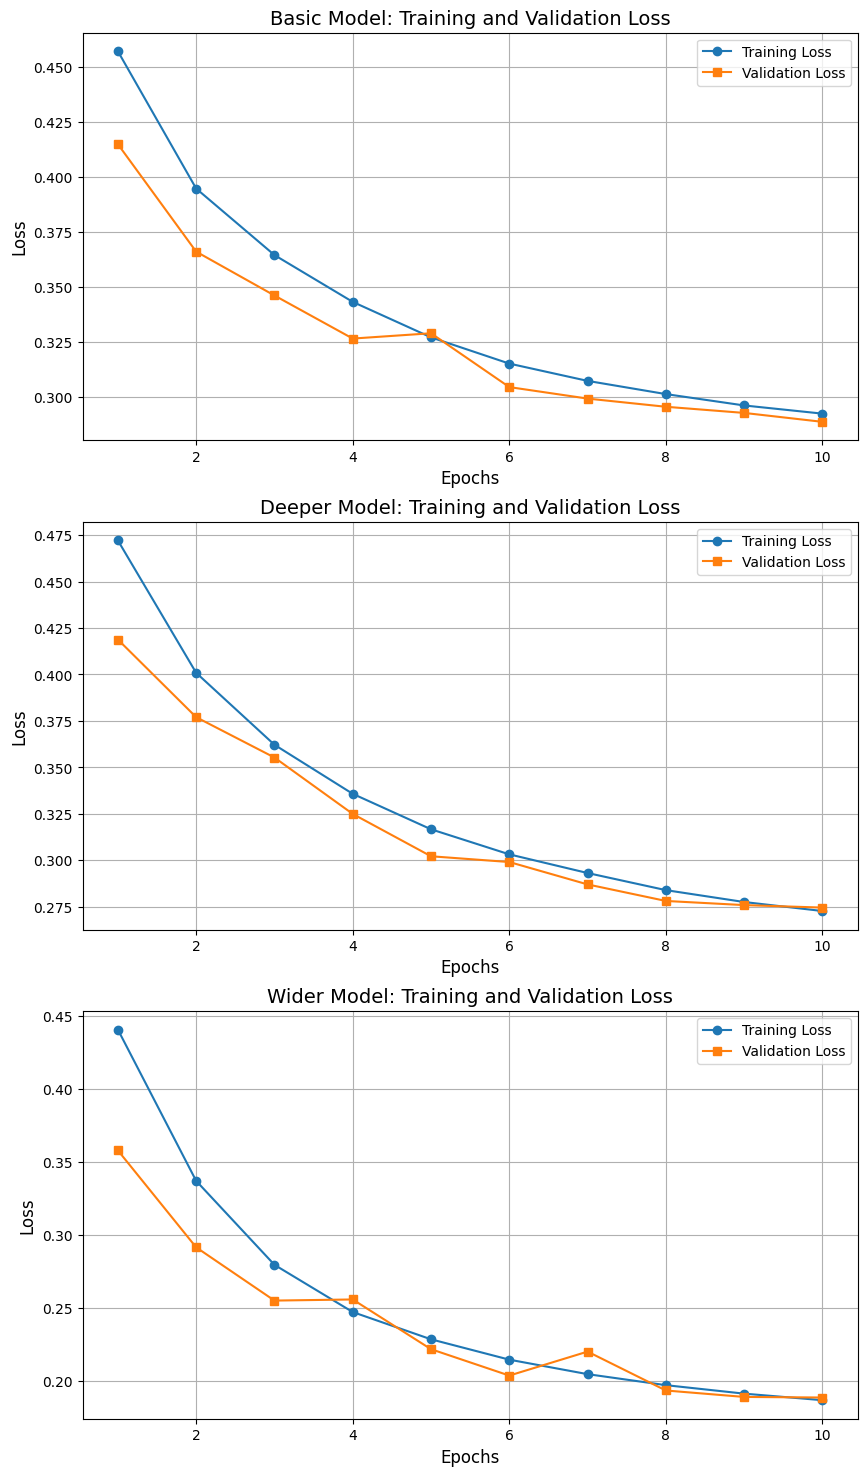

In [15]:
# Plots of all 3 Models

epochs = range(1, 11)




# Create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

axs[0].plot(epochs, basic_hist.history['loss'], label='Training Loss', marker='o')
axs[0].plot(epochs, basic_hist.history['val_loss'], label='Validation Loss', marker='s')
axs[0].set_title('Basic Model: Training and Validation Loss', fontsize=14)
axs[0].set_xlabel('Epochs', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].legend(fontsize=10)
axs[0].grid(True)

# Plot for Model 2
axs[1].plot(epochs, basic_model_deeper_hist.history['loss'], label='Training Loss', marker='o')
axs[1].plot(epochs, basic_model_deeper_hist.history['val_loss'], label='Validation Loss', marker='s')
axs[1].set_title('Deeper Model: Training and Validation Loss', fontsize=14)
axs[1].set_xlabel('Epochs', fontsize=12)
axs[1].set_ylabel('Loss', fontsize=12)
axs[1].legend(fontsize=10)
axs[1].grid(True)

# Plot for Model 3
axs[2].plot(epochs, basic_model_wider_hist.history['loss'], label='Training Loss', marker='o')
axs[2].plot(epochs, basic_model_wider_hist.history['val_loss'], label='Validation Loss', marker='s')
axs[2].set_title('Wider Model: Training and Validation Loss', fontsize=14)
axs[2].set_xlabel('Epochs', fontsize=12)
axs[2].set_ylabel('Loss', fontsize=12)
axs[2].legend(fontsize=10)
axs[2].grid(True)

# Show the plot
plt.show()

All three models show good loss curves when comparing the training and validation losses. This indicates a well-chosen learning rate and minimal overfitting. Among the three, the **wider model** performed the best over the 10 training epochs, achieving the lowest loss.

Initially, I encountered large spikes in loss after a few training epochs, which indicated that the learning rate was too high. To address this, I implemented a **variable learning rate**, which stabilized the training process and resulted in smoother loss curves.

While all models could be trained further, I will focus on the wider model for additional exploration since it demonstrated the best performance. The accuracy plot below further shows that the model has not yet fully plateaued, suggesting potential for further improvement with continued training.


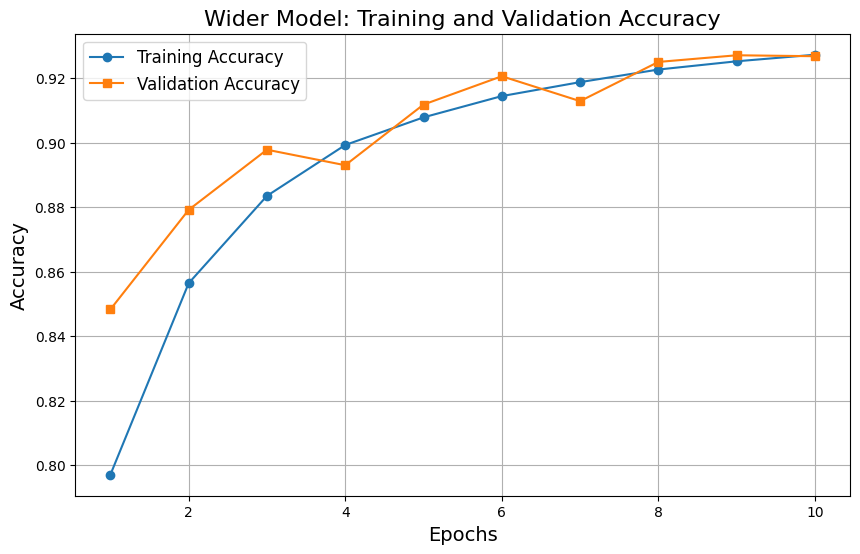

In [16]:
# Plot accuracy for Wider Model
plt.figure(figsize=(10, 6))

plt.plot(epochs, basic_model_wider_hist.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, basic_model_wider_hist.history['val_accuracy'], label='Validation Accuracy', marker='s')

# Add titles and labels
plt.title('Wider Model: Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

### Wider Model Further Training

In [20]:
wider_hist = basic_model_wider.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    initial_epoch=10  # Start from epoch 10
)


Epoch 11/30


2751/2751 [==============================] - 270s 98ms/step - loss: 0.1828 - accuracy: 0.9288 - val_loss: 0.1873 - val_accuracy: 0.9271
Epoch 12/30
2751/2751 [==============================] - 267s 97ms/step - loss: 0.1791 - accuracy: 0.9309 - val_loss: 0.1831 - val_accuracy: 0.9299
Epoch 13/30
2751/2751 [==============================] - 265s 96ms/step - loss: 0.1768 - accuracy: 0.9313 - val_loss: 0.1864 - val_accuracy: 0.9280
Epoch 14/30
2751/2751 [==============================] - 265s 96ms/step - loss: 0.1746 - accuracy: 0.9329 - val_loss: 0.1817 - val_accuracy: 0.9299
Epoch 15/30
2751/2751 [==============================] - 265s 96ms/step - loss: 0.1728 - accuracy: 0.9336 - val_loss: 0.1812 - val_accuracy: 0.9302
Epoch 16/30
2751/2751 [==============================] - 265s 96ms/step - loss: 0.1715 - accuracy: 0.9341 - val_loss: 0.1791 - val_accuracy: 0.9315
Epoch 17/30
2751/2751 [==============================] - 260s 94ms/step - loss: 0.1703 - accuracy: 0.9343 - val_loss: 0.1785

In [21]:
basic_model_wider.save('updated_model.h5')

#### Further Training of Wider Model

After additional training, we can evaluate the validation and training accuracies over the epochs to determine if the model has leveled off. The plot below confirms this leveling off, suggesting that the model has likely been excessively trained. 

In future iterations, implementing **early stopping** could help prevent unnecessary training and reduce the risk of overfitting. Despite this, the model's performance is strong enough to proceed with generating predictions on the test dataset.


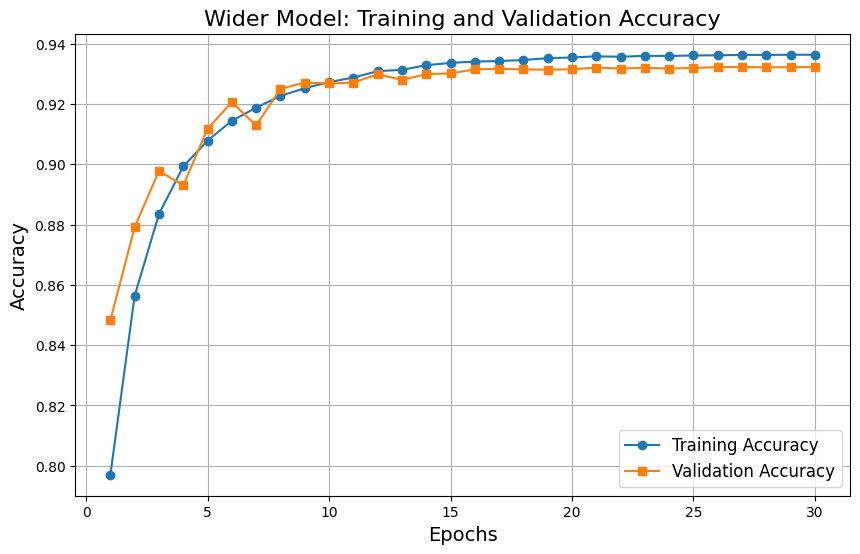

In [22]:
epochs = range(1, 31)
# Plot accuracy for Wider Model
plt.figure(figsize=(10, 6))

wider_acc = basic_model_wider_hist.history['accuracy']
wider_acc.extend(wider_hist.history['accuracy'])

wider_val_acc = basic_model_wider_hist.history['val_accuracy']
wider_val_acc.extend(wider_hist.history['val_accuracy'])

plt.plot(epochs, wider_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, wider_val_acc, label='Validation Accuracy', marker='s')

# Add titles and labels
plt.title('Wider Model: Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [23]:
# Prediction on the test dataset
test_image_folder = "./data/test/"

# Function to load and preprocess an image
def load_test_image(image_path):
    image = Image.open(image_path)
    return tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # Normalize

# List only .tif files in the test image folder
test_image_paths = [
    os.path.join(test_image_folder, file_name)
    for file_name in os.listdir(test_image_folder)
    if file_name.lower().endswith('.tif')  # Case-insensitive filter for .tif files
]

# Create a generator for test images
def test_generator():
    for image_path in test_image_paths:
        yield load_test_image(image_path), os.path.basename(image_path)  # Include file names for reference

# Create the tf.data.Dataset for the test set
test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),  # Adjust shape for your dataset
        tf.TensorSpec(shape=(), dtype=tf.string)  # File names as identifiers
    )
).batch(32, drop_remainder=False)  # Batch size for prediction



# Predict test images
predictions = basic_model_wider.predict(test_dataset.map(lambda img, _: img))  # Pass only images for prediction



1796/1796 [==============================] - 65s 36ms/step


In [24]:
binary_predictions = (predictions > 0.5).astype(int)  # Maps >0.5 to 1, otherwise 0

unbatched_results = []

for _, filenames in test_dataset.as_numpy_iterator():
    unbatched_results.extend(filenames)
# Associate predictions with image file names
decoded_results = [s.decode("utf-8").split('.')[0] for s in unbatched_results]



results = {"id": decoded_results, "label": binary_predictions.flatten().tolist()}

# Convert to a DataFrame
results_df = pd.DataFrame(results, columns=["id", "label"])

# Save to a CSV file with the desired header
results_df.to_csv("test_predictions.csv", index=False, encoding="utf-8")

#### Initial Attempt at Classifying the Test Set

After uploading the test results to Kaggle, I achieved a public score of **0.8668** and a private score of **0.8155**. These results were somewhat surprising given the strong validation performance, likely indicating some overfitting. This could be attributed to manually selecting the model with the best validation accuracy from the three tested. To address this, I plan to implement regularization strategies in the next iteration of the model.

#### More Advanced Model

To improve generalization and reduce overfitting, I will make the following adjustments:

1. **Dropout Layer + Increased Capacity**:
   - Add dropout after convolutional blocks and in between dense layers to act as a regularization mechanism.
   - Since regularization is being applied, I can afford to increase the model's capacity by increasing the filter sizes in the CNN layers and the neurons in the dense layers.

2. **Early Stopping**:
   - Implement the early stopping callback to halt training once the validation performance stops improving.

3. **Learning Rate Optimization**:
   - Perform a quick search to find the optimal learning rate instead of manually guessing.
   - Following the method suggested in *"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow"*, I will:
     - Start with a very low learning rate (10^-6).
     - Gradually increase the learning rate at each step by a constant factor, up to a high value (1).
     - Plot the loss as a function of the learning rate and select the learning rate just before the loss starts to diverge (rapidly increase).

These changes aim to build a more robust and better-performing model that balances capacity and generalization, providing stronger results on the test set.




2751/2751 [==============================] - 406s 146ms/step - loss: 0.6191 - accuracy: 0.6544 - val_loss: 0.6753 - val_accuracy: 0.5949


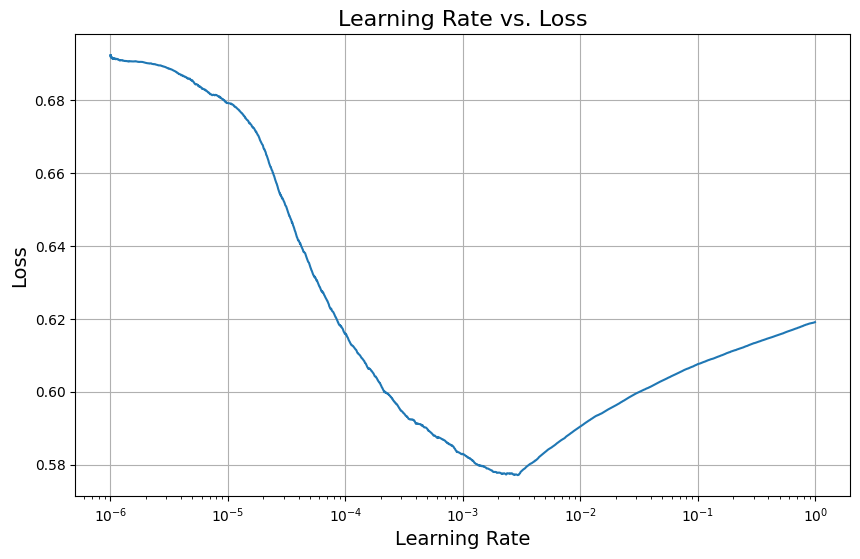

In [25]:
# Define a custom callback to adjust learning rate and record the losses
class LearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, min_lr, max_lr, steps):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.lrs = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        # Record the learning rate and loss
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)
        self.losses.append(min(1, logs['loss']))
        
        # Increase the learning rate exponentially
        new_lr = lr * (self.max_lr / self.min_lr) ** (1 / self.steps)
        tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)


advanced_model = tf.keras.Sequential([
    tf.keras.Input(shape=(96, 96, 3)),
    
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

initial_learning_rate = 1e-6
advanced_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


min_lr = 1e-6
max_lr = 1
steps = 2751

lr_scheduler = LearningRateScheduler(min_lr, max_lr, steps)
history = advanced_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=1,  # Single epoch to test the learning rate range
    callbacks=[lr_scheduler],
)
# Plot the loss as a function of the learning rate
plt.figure(figsize=(10, 6))
plt.semilogx(lr_scheduler.lrs, lr_scheduler.losses)
plt.title("Learning Rate vs. Loss", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.show()


#### Optimal Learning Rate

Based on the training plot above, the maximum learning rate is approximately **2 × 10^-3**, so I will select an optimal learning rate of **10^-3**. With this learning rate and early stopping implemented, I will now proceed to train the advanced model.


In [ ]:

advanced_model = tf.keras.Sequential([
    tf.keras.Input(shape=(96, 96, 3)),
    
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


advanced_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=5,                # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

advanced_model_hist = advanced_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[early_stopping]
)
advanced_model.save('updated_model_increased_dropout.h5')


Epoch 1/50
2751/2751 [==============================] - 586s 212ms/step - loss: 0.4303 - accuracy: 0.8094 - val_loss: 0.3930 - val_accuracy: 0.8552
Epoch 2/50
2751/2751 [==============================] - 476s 173ms/step - loss: 0.2735 - accuracy: 0.8911 - val_loss: 0.2706 - val_accuracy: 0.9048
Epoch 3/50
2751/2751 [==============================] - 476s 173ms/step - loss: 0.2223 - accuracy: 0.9144 - val_loss: 0.2314 - val_accuracy: 0.9228
Epoch 4/50
2751/2751 [==============================] - 477s 173ms/step - loss: 0.1934 - accuracy: 0.9274 - val_loss: 0.1956 - val_accuracy: 0.9334
Epoch 5/50
2751/2751 [==============================] - 475s 172ms/step - loss: 0.1714 - accuracy: 0.9372 - val_loss: 0.1831 - val_accuracy: 0.9372
Epoch 6/50
2751/2751 [==============================] - 476s 173ms/step - loss: 0.1555 - accuracy: 0.9438 - val_loss: 0.1676 - val_accuracy: 0.9400
Epoch 7/50
2751/2751 [==============================] - 477s 173ms/step - loss: 0.1396 - accuracy: 0.9495 - val_

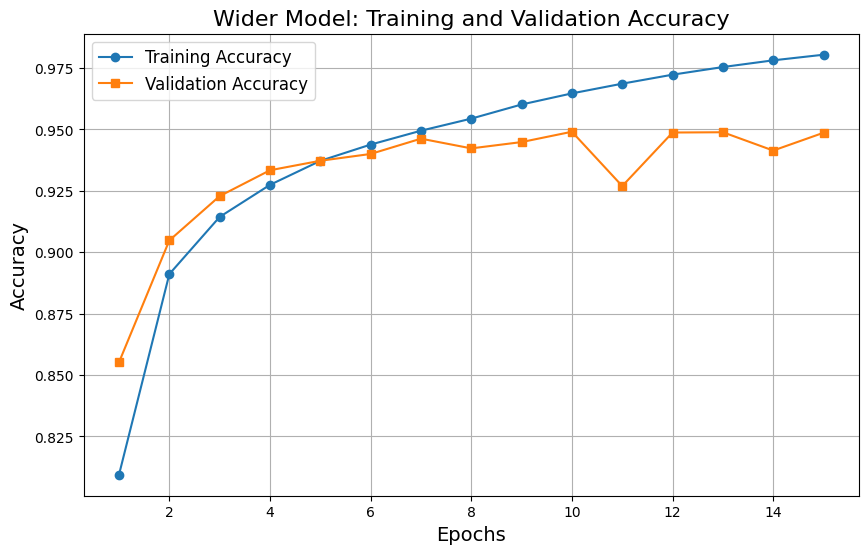

In [33]:
num_epochs = len(advanced_model_hist.epoch)
# Plot accuracy for Wider Model
plt.figure(figsize=(10, 6))

plt.plot(range(1, num_epochs + 1), advanced_model_hist.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), advanced_model_hist.history['val_accuracy'], label='Validation Accuracy', marker='s')

# Add titles and labels
plt.title('Wider Model: Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

#### Advanced Model Accuracy vs Epoch

Despite the addition of dropout layers, the training accuracy in the later epochs still surpasses the validation accuracy, indicating some degree of overfitting. However, this overfitting is somewhat mitigated by the use of early stopping. 

That said, the validation accuracy shows noticeable improvement compared to the initial models. Given this progress, I will now evaluate the model's performance on the test set to see how much the score improves.


In [34]:
predictions = advanced_model.predict(test_dataset.map(lambda img, _: img))  # Pass only images for prediction
binary_predictions = (predictions > 0.5).astype(int)  # Maps >0.5 to 1, otherwise 0

unbatched_results = []

for _, filenames in test_dataset.as_numpy_iterator():
    unbatched_results.extend(filenames)
# Associate predictions with image file names
decoded_results = [s.decode("utf-8").split('.')[0] for s in unbatched_results]



results = {"id": decoded_results, "label": binary_predictions.flatten().tolist()}

# Convert to a DataFrame
results_df = pd.DataFrame(results, columns=["id", "label"])

# Save to a CSV file with the desired header
results_df.to_csv("test_advanced_predictions.csv", index=False, encoding="utf-8")

1796/1796 [==============================] - 120s 67ms/step


## Conclusion

The advanced model achieved a public score of **0.8716** and a private score of **0.8522**, marking a meaningful improvement over the initial models. However, there remains a noticeable gap between the validation and test set accuracy, suggesting potential overfitting or that the test set contains distinct examples not well-represented in the training data.

### Areas for Further Improvement:
1. **Data Augmentation**:
   - Employing data augmentation techniques (e.g., rotation, flipping, scaling, or color adjustments) could help the model generalize better to unseen examples by artificially expanding the diversity of the training dataset.

2. **Layer-Level Regularization**:
   - Adding L2 regularization could further combat overfitting while maintaining the model's performance.

3. **Model Architecture Tweaks**:
   - More complex models can pull out more data patterns and potentially lead to higher prediction rates. Taking a prebuilt architecture made for images like Google's InceptionNet (or even using their inception cells) and applying transfer learning would certainly increase model performance as well


Overall, the improvements made in this iteration highlight the importance of thoughtful regularization and parameter tuning. Future iterations should focus on balancing model complexity with robust regularization techniques and exploring ways to improve generalization across unseen datasets.
